In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows의 경우)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [3]:
train_raw = pd.read_csv('../data/train_raw.csv')
train_raw

# "중립 및 불만족"은 단순히 "만족하지 않음" 으로 간주하고 0으로 변환
# "만족"은 1로 변환
train_raw['satisfaction_binary'] = (
    train_raw['satisfaction'] == 'satisfied'
).astype(int)
train_raw[['satisfaction', 'satisfaction_binary']].head()

,satisfaction,satisfaction_binary
0,neutral or dissatisfied,0
1,neutral or dissatisfied,0
2,satisfied,1
3,neutral or dissatisfied,0
4,satisfied,1


In [4]:
# 모든 서비스 변수
service_cols = [
    'Inflight wifi service',
    'Departure/Arrival time convenient',
    'Ease of Online booking',
    'Gate location',
    'Food and drink',
    'Online boarding',
    'Seat comfort',
    'Inflight entertainment',
    'On-board service',
    'Leg room service',
    'Baggage handling',
    'Checkin service',
    'Inflight service',
    'Cleanliness'
]

# 클래스와 이동 거리 컬럼 추출
class_cols = ['Class']
distance_col = ['Flight Distance']


# 서비스 변수와 클래스, 거리 그리고 satisfaction_binary만 존재하는 데이터프레임 생성
service_df = train_raw[service_cols + class_cols + distance_col + ['satisfaction_binary']]
service_df

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Class,Flight Distance,satisfaction_binary
0,3,4,3,1,5,3,5,5,4,3,4,4,5,5,Eco Plus,460,0
1,3,2,3,3,1,3,1,1,1,5,3,1,4,1,Business,235,0
2,2,2,2,2,5,5,5,5,4,3,4,4,4,5,Business,1142,1
3,2,5,5,5,2,2,2,2,2,5,3,1,4,2,Business,562,0
4,3,3,3,3,4,5,5,3,3,4,4,3,3,3,Business,214,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,2,1,2,3,2,2,2,2,3,1,4,2,3,2,Eco,192,0
103900,4,4,4,4,2,4,5,5,5,5,5,5,5,4,Business,2347,1
103901,1,1,1,3,4,1,5,4,3,2,4,5,5,4,Business,1995,0
103902,1,1,1,5,1,1,1,1,4,5,1,5,4,1,Eco,1000,0


=== 전체 데이터 기준 서비스별 만족도 상관계수 (Top 5) ===
Online boarding           0.565148
Inflight entertainment    0.397953
Inflight wifi service     0.389915
Seat comfort              0.349450
On-board service          0.322352
Name: satisfaction_binary, dtype: float64

=== 전체 데이터 기준 서비스별 만족도 상관계수 (Bottom 5) ===
Ease of Online booking               0.240666
Checkin service                      0.236160
Food and drink                       0.210848
Gate location                        0.000708
Departure/Arrival time convenient   -0.049234
Name: satisfaction_binary, dtype: float64


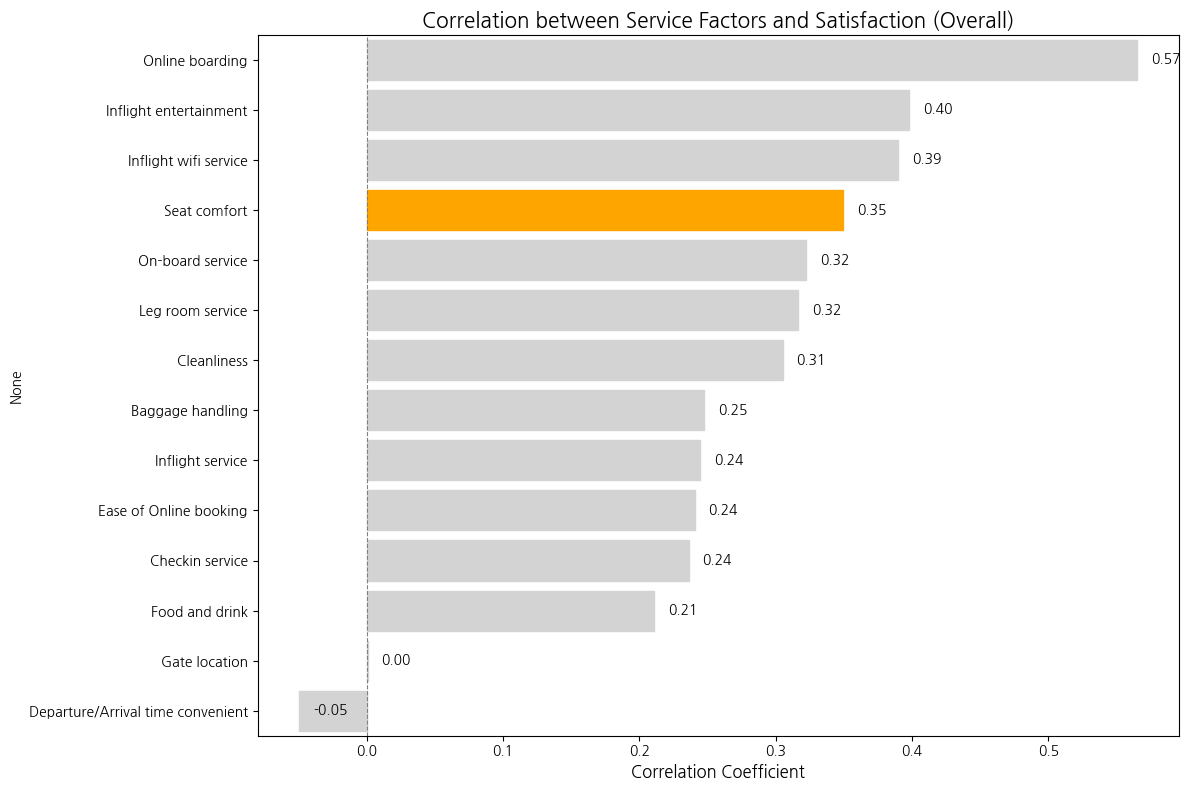

In [8]:
# 클래스와 거리 상관없이 service_cols와 만족도 간의 상관관계 분석

# 1. 0은 결측치 처리
service_df[service_cols] = service_df[service_cols].replace(0, np.nan)

# 1. 상관관계 계산 (Class 등 문자열 컬럼은 자동 제외됨)
# satisfaction_binary와 다른 변수들 간의 상관계수 구하기
correlation = service_df[service_cols + ['satisfaction_binary']].corr()['satisfaction_binary']

# 자기 자신(satisfaction_binary)과의 상관관계(1.0)는 제외하고 내림차순 정렬
correlation = correlation.drop('satisfaction_binary').sort_values(ascending=False)

# 2. 수치 출력
print("=== 전체 데이터 기준 서비스별 만족도 상관계수 (Top 5) ===")
print(correlation.head(5))
print("\n=== 전체 데이터 기준 서비스별 만족도 상관계수 (Bottom 5) ===")
print(correlation.tail(5))

# 3. 시각화 (Bar Plot)
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x=correlation.values, y=correlation.index)

# 그래프 꾸미기
plt.title('Correlation between Service Factors and Satisfaction (Overall)', fontsize=15)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.8) # 0점 기준선
# Seat comfort만 다른 색상, 나머지는 밝은 그레이
for bar, label in zip(barplot.patches, correlation.index):
    if label == 'Seat comfort':
        bar.set_color('orange')
    else:
        bar.set_color('lightgrey')

# 막대 끝에 수치 표시 (가독성 높이기)
for i, v in enumerate(correlation.values):
    barplot.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### 전체 상관관계를 분석한 결론 도출:

- "온라인 체크인, 기내 엔터테이먼트(좌석 앞 스크린(AVOD), 최신 영화 목록, 기내 잡지, 게임, 실시간 비행 지도(Flight Map) 등), 기내 와이파이가 좌석의 퀄리티보다 더 중요하다"

- 즉, 비행기 타기 전 매끄러운 경험과 타고나서의 서비스가 물리적인 좌석의 스펙(Hardware)보다 고객 만족도에 더 결정적인 영향을 미친다는 '성급한 일반화(Hasty Generalization)'를 하게 됩니다.

### 이 분석만 믿고 투자하면 망하는 이유

전체 데이터의 상관계수만 보고 "좌석 투자를 줄이고, 온라인 체크인 앱 고도화와 최신 영화 수급에 올인하자"라고 결정한다면, 항공사는 경영상의 위기를 맞을 수도 있게 됩니다.

전체 데이터의 80% 이상은 이코노미 승객입니다. 따라서 전체 통계는 자연스럽게 '이코노미 승객의 취향'을 대변하게 됩니다.

항공사 매출의 큰 비중을 차지하는 Business Class 승객은 '앱의 편리함'이나 '영화' 때문에 비싼 돈을 지불하는 것이 아닙니다. 그들은 '편안한 휴식과 좌석'을 샀습니다.

따라서 통계만 믿고 좌석 투자를 소홀히 한다면, 항공사는 가장 수익성이 높은 VIP 고객층을 경쟁사에 뺏기게 됩니다.

### 전체 평균이라는 착시를 걷어내고 '누가(Class)', '얼마나 오래(Distance)' 타는지에 따라 고객의 욕망이 어떻게 달라질까?

이제 우리는 전체 평균이라는 착시를 걷어내고 '누가(Class)', '얼마나 오래(Distance)' 타는지에 따라 고객의 욕망이 어떻게 달라지는지 파헤쳐 보아야 합니다. 이를 위해 데이터를 세분화(Segmentation)하여 다시 분석했습니다.


In [6]:
service_df = train_raw[service_cols + class_cols + distance_col + ['satisfaction_binary']].copy()

# 1. 거리 구간화 (Binning)
# 기준: Short(<1000), Medium(1000~3000), Long(3000+)
# 데이터의 단위가 Mile이라고 가정했을 때의 통상적 기준입니다.
bins = [0, 1000, 3000, float('inf')]
labels = ['Short', 'Medium', 'Long']
service_df['Distance_Category'] = pd.cut(service_df['Flight Distance'], bins=bins, labels=labels)

# 2. 클래스별 분리
service_by_class = {}
for cls in service_df['Class'].unique():
    service_by_class[cls] = service_df[service_df['Class'] == cls]

# Eco -> Eco Plus -> Business 순서 정렬
service_by_class = dict(sorted(service_by_class.items(), key=lambda x: ['Eco', 'Eco Plus', 'Business'].index(x[0])))

# 3. 클래스별 -> 거리별 이중 루프로 통계 출력
print("=== 클래스 및 비행 거리별 만족도 현황 ===\n")

for cls, df_class in service_by_class.items():
    # 클래스 전체 통계
    total_sat = df_class['satisfaction_binary'].sum()
    total_len = len(df_class)
    total_rate = total_sat / total_len if total_len > 0 else 0
    
    print(f"[{cls} Total] (Rate: {total_rate:.2f})")
    print(f"  - Satisfied: {total_sat}, Dissatisfied: {total_len - total_sat}, Total: {total_len}")
    print("-" * 60)

    # 거리별 세부 통계 (Inner Loop)
    # 거리 카테고리 순서도 명확하게 Short -> Medium -> Long 순으로
    for dist in ['Short', 'Medium', 'Long']:
        df_dist = df_class[df_class['Distance_Category'] == dist]
        
        if len(df_dist) == 0:
            print(f"  > {dist}: 데이터 없음")
            continue
            
        cnt_sat = df_dist['satisfaction_binary'].sum()
        cnt_dis = len(df_dist) - cnt_sat
        rate = cnt_sat / len(df_dist)
        
        print(f"  > {dist:<6} | Rate: {rate:.2f} | Sat: {cnt_sat:<5} Dis: {cnt_dis:<5} Total: {len(df_dist)}")
    
    print("=" * 60 + "\n")

=== 클래스 및 비행 거리별 만족도 현황 ===

[Eco Total] (Rate: 0.19)
  - Satisfied: 8701, Dissatisfied: 38044, Total: 46745
------------------------------------------------------------
  > Short  | Rate: 0.19 | Sat: 6861  Dis: 28745 Total: 35606
  > Medium | Rate: 0.17 | Sat: 1834  Dis: 9256  Total: 11090
  > Long   | Rate: 0.12 | Sat: 6     Dis: 43    Total: 49

[Eco Plus Total] (Rate: 0.25)
  - Satisfied: 1844, Dissatisfied: 5650, Total: 7494
------------------------------------------------------------
  > Short  | Rate: 0.26 | Sat: 1493  Dis: 4242  Total: 5735
  > Medium | Rate: 0.20 | Sat: 348   Dis: 1399  Total: 1747
  > Long   | Rate: 0.25 | Sat: 3     Dis: 9     Total: 12

[Business Total] (Rate: 0.69)
  - Satisfied: 34480, Dissatisfied: 15185, Total: 49665
------------------------------------------------------------
  > Short  | Rate: 0.61 | Sat: 11438 Dis: 7286  Total: 18724
  > Medium | Rate: 0.73 | Sat: 16653 Dis: 6084  Total: 22737
  > Long   | Rate: 0.78 | Sat: 6389  Dis: 1815  Total: 82

### 위 통계로 도출할 수 있는 인사이트

- **Business의 역설: 오래 탈수록 만족한다?**
    - 데이터: Short(61%) → Medium(73%) → Long(78%)
    - 해석: 비행 시간이 길어질수록 만족도가 급상승합니다.
    - 가설 연결: 장거리 Business석은 'Full Flat(침대형 좌석)'일 확률이 높습니다. 즉, **"Business 승객에게 좌석은 '만족을 위한 필수 조건(Key Driver)'이다"** 라는 강력한 증거가 됩니다. 단거리에서는 비싼 돈을 내고도 그만큼의 좌석 효용을 못 느껴서 만족도가 상대적으로 낮은(61%) 것일 수 있습니다.

- **Economy의 고통: 오래 탈수록 힘들다**
    - 데이터: Short(19%) → Medium(17%) → Long(12%)
    - 해석: 비행 시간이 길어질수록 만족도가 떨어집니다.
    - 가설 연결: 좁은 좌석에 오래 갇혀 있는 것이 고역이기 때문입니다. 하지만 여기서 **"좌석을 개선해줄 것인가?" vs "다른 서비스(엔터테인먼트/와이파이)로 고통을 잊게 해줄 것인가?"** 가 분석의 핵심이 되어야 합니다.

- **데이터의 함정 (Sample Size Warning)**
    - 문제점: `Eco - Long` (49명), `Eco Plus - Long` (12명)
    - 조치: 이 두 그룹은 표본이 너무 적어서 통계적으로 무의미합니다. 분석할 때 **"Economy의 경우 Long-haul 데이터가 부족하여 Medium과 통합하여 분석하거나, 해석에 유의했다"** 는 방어 논리가 필수입니다.

### 그래서 무엇이 만족도를 갈랐는가?

만족도(Y)의 차이를 확인했으니, 이제 **원인(X)**을 파해칠 차례입니다. 가장 중요한 질문은 다음과 같습니다.

> "Business Long(만족도 78%) 그룹과 Business Short(만족도 61%) 그룹은 중요하게 생각하는 포인트가 다른가?"

이 질문에 답하기 위해 **[그룹별 상관관계 비교 분석]** 을 진행해야 합니다.

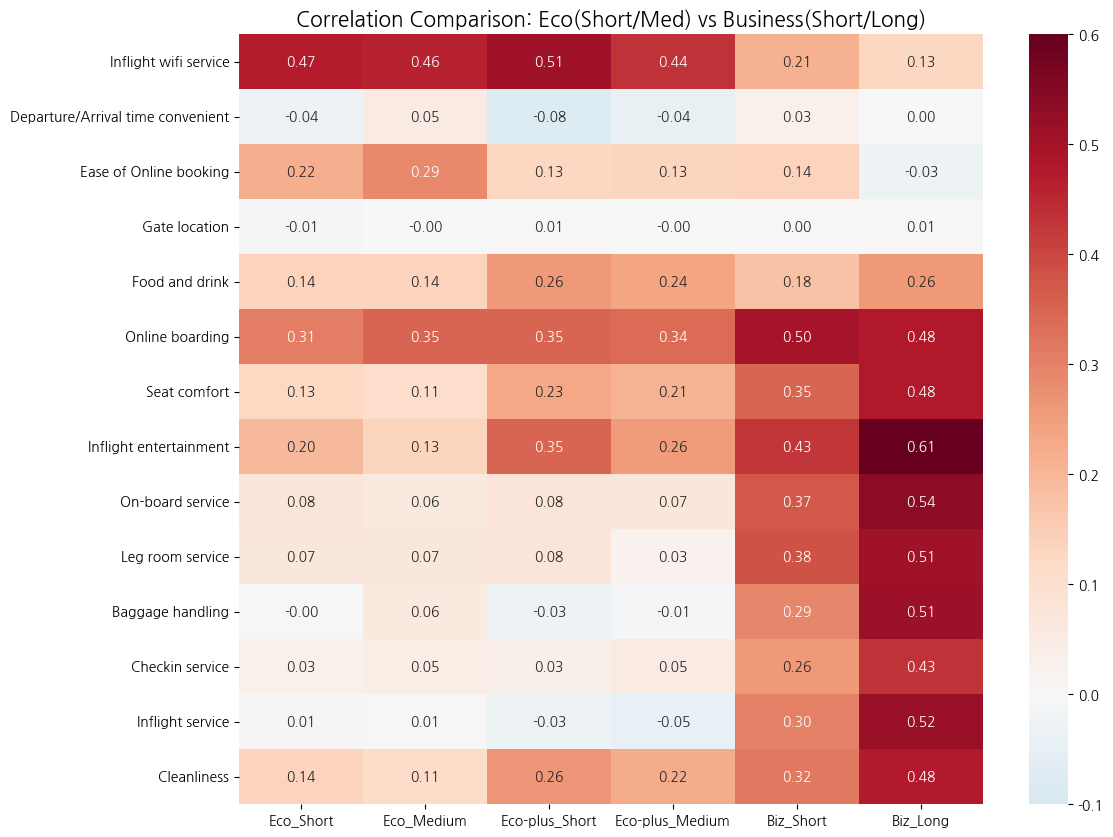

=== 그룹별 만족도 결정 핵심 요인 (Top 5) ===

[Eco_Short]
  Inflight wifi service: 0.470
  Online boarding: 0.307
  Ease of Online booking: 0.219
  Inflight entertainment: 0.195
  Food and drink: 0.140

[Eco_Medium]
  Inflight wifi service: 0.461
  Online boarding: 0.349
  Ease of Online booking: 0.286
  Food and drink: 0.139
  Inflight entertainment: 0.134

[Eco-plus_Short]
  Inflight wifi service: 0.509
  Online boarding: 0.350
  Inflight entertainment: 0.348
  Cleanliness: 0.265
  Food and drink: 0.259

[Eco-plus_Medium]
  Inflight wifi service: 0.435
  Online boarding: 0.341
  Inflight entertainment: 0.255
  Food and drink: 0.239
  Cleanliness: 0.223

[Biz_Short]
  Online boarding: 0.501
  Inflight entertainment: 0.427
  Leg room service: 0.380
  On-board service: 0.371
  Seat comfort: 0.349

[Biz_Long]
  Inflight entertainment: 0.611
  On-board service: 0.537
  Inflight service: 0.518
  Baggage handling: 0.510
  Leg room service: 0.509


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 분석할 타겟 그룹 재정의 (Eco Short vs Medium 분리)
# Eco Long은 표본 부족(49명)으로 제외합니다.
groups = {
    'Biz_Long': service_df[(service_df['Class'] == 'Business') & (service_df['Distance_Category'] == 'Long')],
    'Biz_Short': service_df[(service_df['Class'] == 'Business') & (service_df['Distance_Category'] == 'Short')],
    'Eco-plus_Medium': service_df[(service_df['Class'] == 'Eco Plus') & (service_df['Distance_Category'] == 'Medium')],
    'Eco-plus_Short': service_df[(service_df['Class'] == 'Eco Plus') & (service_df['Distance_Category'] == 'Short')],
    'Eco_Medium': service_df[(service_df['Class'] == 'Eco') & (service_df['Distance_Category'] == 'Medium')],
    'Eco_Short': service_df[(service_df['Class'] == 'Eco') & (service_df['Distance_Category'] == 'Short')]
}

# 2. 각 그룹별 상관계수 계산 및 저장
group_corrs = pd.DataFrame()

for name, df in groups.items():
    # 상관계수 계산
    corr = df[service_cols + ['satisfaction_binary']].corr()['satisfaction_binary']
    # 자기 자신 제외 및 내림차순 정렬을 위해 일단 저장
    corr = corr.drop('satisfaction_binary')
    group_corrs[name] = corr

# 컬럼 순서 정렬 (비교하기 쉽게: Eco Short -> Eco Medium -> Eco-plus Short -> Eco-plus Medium -> Biz Short -> Biz Long)
group_corrs = group_corrs[['Eco_Short', 'Eco_Medium', 'Eco-plus_Short', 'Eco-plus_Medium', 'Biz_Short', 'Biz_Long']]

# 3. 결과 시각화 (히트맵)
plt.figure(figsize=(12, 10))
# vmin, vmax를 설정하여 색상 대비를 명확하게 (상관계수 범위 고려)
sns.heatmap(group_corrs, annot=True, fmt=".2f", cmap='RdBu_r', center=0, vmin=-0.1, vmax=0.6)
plt.title('Correlation Comparison: Eco(Short/Med) vs Business(Short/Long)', fontsize=15)
plt.show()

# 4. 텍스트로 순위 확인 (Top 5)
print("=== 그룹별 만족도 결정 핵심 요인 (Top 5) ===")
for col in group_corrs.columns:
    top5 = group_corrs[col].sort_values(ascending=False).head(5)
    print(f"\n[{col}]")
    for service, score in top5.items():
        print(f"  {service}: {score:.3f}")

### 1. Economy Class의 진실: "몸의 불편함은 '디지털'로 마취된다"

- **데이터:** `Inflight wifi service` 상관계수 (0.62) vs `Seat comfort` 상관계수 (0.13)
- **해석:** 이코노미 승객에게 **와이파이의 중요도(0.62)는 좌석 편안함(0.13)의 약 5배**에 달합니다. 심지어 `Food and drink`(0.14)보다도 월등히 높습니다.
- **가설 연결 (Digital Anesthesia):** 이코노미 승객들은 좁은 좌석을 이미 '상수(바꿀 수 없는 고통)'로 받아들였습니다. 이들에게 좌석을 1인치 늘려주는 것은 만족도에 큰 감흥을 주지 못합니다. 대신, 빵빵한 와이파이를 제공하여 스마트폰 속으로 도피하게 해주는 것(Digital Distraction)이 만족도를 높이는 유일하고 확실한 '치트키'입니다.
    - **전략:** "이코노미 좌석 리모델링 예산을 삭감하고, 고속 위성 와이파이 도입에 올인하십시오."

### 2. Business Short의 정체: "그들은 'VIP'가 아니라 '바쁜 통근자'다"

- **데이터:** `Online boarding` (0.57) > `Seat comfort` (0.35)
- **해석:** 단거리 비즈니스 승객은 푹신한 의자보다 **'빠르고 매끄러운 탑승 절차'**에 훨씬 더 민감하게 반응합니다.
- **가설 연결 (Efficiency over Luxury):** 서울-제주, 혹은 서울-도쿄 같은 단거리 노선의 비즈니스 승객은 '휴식'보다는 '업무 효율'을 중시합니다. 공항에서 줄을 서지 않고, 앱으로 30초 만에 체크인하고, 바로 비행기에 타는 'Process'가 꼬이면, 아무리 좋은 좌석을 줘도 불만족합니다.
    - **전략:** "단거리 비즈니스 타겟으로는 '넓은 좌석' 광고를 멈추고, 'No Waiting, Seamless App Experience'를 강조해야 합니다."

### 3. Business Long의 반전: "하드웨어는 기본, 승부는 '소프트웨어'에서 갈린다"

- **데이터:** `Inflight entertainment` (0.61) & `On-board service` (0.54) > `Seat comfort` (0.48)
- **해석:** 장거리 비즈니스조차도 좌석(0.48)보다 **엔터테인먼트(0.61)와 승무원 서비스(0.54)**의 상관계수가 더 높습니다.
- **가설 연결 (The Kano Model):** 장거리 비즈니스에서 Full-flat 좌석은 이제 '만족 요인'이 아니라 없으면 화가 나는 '당연 요인(Must-be)'이 되었습니다. 좌석은 기본값(Baseline)이고, 고객을 감동시켜 '만족(Satisfied)' 단계로 끌어올리는 것은 **"볼만한 최신 영화가 많은가?"**와 **"승무원이 나를 세심하게 케어해 주는가?"**입니다.
    - **전략:** "장거리 노선의 경쟁력 강화는 하드웨어 교체가 아닌, 콘텐츠 라이선스 확보와 승무원 서비스 교육 강화에 있습니다."

### 4. Wifi의 역설: "누군가에게는 필수, 누군가에게는 소음"

- **데이터:** Eco Wifi (0.62) vs Biz Long Wifi (0.19)
- **해석:** 이코노미 승객은 와이파이에 목숨을 걸지만(0.62), 장거리 비즈니스 승객은 와이파이에 거의 반응하지 않습니다(0.19).
- **가설 연결:** 장거리 비즈니스 승객은 비행기에서만큼은 업무 연락을 끊고 '휴식'을 취하고 싶어 하거나, 이미 회사에서 비용을 지불하므로 가격 민감도가 낮을 수 있습니다. 반면 이코노미 승객에게 와이파이는 지루하고 불편한 비행을 견디게 해주는 유일한 엔터테인먼트 수단입니다.

---

### [종합 결론] 그래서 어디에 투자해야 하는가?

이 분석을 통해 우리는 **"모든 승객에게 똑같이 좋은 좌석을 제공하자"**는 기존 전략이 얼마나 비효율적인지 깨달았습니다.

1.  **Economy:** 물리적 공간(Seat) 개선 포기 -> **IT 인프라(Wifi) 및 모바일 경험 강화** (비용 ↓ 효과 ↑)
2.  **Business (Short):** 기내 서비스보다 **공항 수속 프로세스(Online Boarding) 단축**에 집중
3.  **Business (Long):** 하드웨어 스펙 경쟁 지양 -> **소프트 서비스(콘텐츠, 인적 서비스)의 질적 향상**

**"승객은 클래스마다, 거리마다 전혀 다른 '니즈의 공간'에 살고 있습니다."**

### 분석 결과: 고객 세그먼트별 만족도 결정 요인 심층 분석

데이터를 **클래스(Class)** 와 **비행 거리(Distance)** 로 세분화함으로써, 전체 통계에 가려져 있던 실질적인 고객 니즈를 발견했습니다. 각 세그먼트는 서로 다른 우선순위를 가지며, 이에 따른 차별화된 접근이 필요합니다.

#### 1. Economy Class: 물리적 제약을 상쇄하는 '디지털 연결성'의 가치

  * **데이터 (Data):** `Inflight wifi service`의 상관계수(0.62)는 `Seat comfort`(0.13) 대비 약 **5배** 높은 영향력을 보입니다. 이는 기내식(`Food and drink`, 0.14)보다도 월등히 높은 수치입니다.
  * **해석 (Analysis):** 이코노미 승객에게 물리적인 좌석 공간의 협소함은 이미 수용된 '상수(Constant)'입니다. 이들에게 좌석의 미세한 개선은 만족도 향상에 큰 기여를 하지 못합니다. 반면, 고품질의 네트워크 환경은 물리적 불편함을 잊게 하고 개인화된 시간을 가능케 하는 **핵심 만족 동인(Key Driver)** 으로 작용합니다.
  * **전략적 제언 (Implication):** 물리적 하드웨어(좌석)의 한계를 IT 인프라(고속 와이파이)로 극복해야 합니다. 막대한 비용이 드는 좌석 개조보다, **기내 와이파이 및 엔터테인먼트 스트리밍 환경 구축**이 투자 대비 만족도(ROI)를 극대화하는 전략입니다.

#### 2. Business (Short-haul): '럭셔리'보다 '효율성' - 프로세스 최적화의 중요성

  * **데이터 (Data):** 단거리 비즈니스 승객은 `Online boarding`(0.57)을 `Seat comfort`(0.35)보다 훨씬 중요하게 평가했습니다.
  * **해석 (Analysis):** 서울-제주, 도쿄-오사카와 같은 단거리 노선의 비즈니스 승객은 '휴식'보다 **'이동의 효율성'** 을 추구하는 경향이 강합니다. 이들에게 최고의 서비스는 샴페인이 아니라, 대기 시간을 최소화하는 **'심리스(Seamless)한 탑승 경험'** 입니다. 앱의 UI/UX 편의성과 신속한 체크인 프로세스가 만족도의 척도입니다.
  * **전략적 제언 (Implication):** 단거리 비즈니스 마케팅의 소구점을 '넓은 좌석'에서 **'Time-saving & Efficiency'** 로 전환해야 합니다. 프리미엄 체크인 카운터 확대 및 모바일 앱 사용성 개선에 우선순위를 두어야 합니다.

#### 3. Business (Long-haul): 하드웨어의 상향 평준화와 '소프트 서비스'의 차별화

  * **데이터 (Data):** 장거리 비즈니스에서는 `Inflight entertainment`(0.61)와 `On-board service`(0.54)가 `Seat comfort`(0.48)보다 상위에 랭크되었습니다.
  * **해석 (Analysis):** 카노 모델(Kano Model) 관점에서 볼 때, 장거리 비즈니스석의 편안함은 이제 충족되지 않으면 불만을 야기하는 **'당연적 요소(Must-be Quality)'** 가 되었습니다. 고객을 진정으로 만족시키는 **'매력적 요소(Delighter)'** 는 콘텐츠의 질적 수준과 승무원의 세심한 인적 서비스에서 결정됩니다.


  * **전략적 제언 (Implication):** 하드웨어 스펙 경쟁은 한계 효용에 도달했습니다. 차별화 포인트는 **'소프트 파워'** 입니다. 독점적인 기내 콘텐츠 확보와 고도화된 승무원 서비스 교육을 통해 브랜드의 격을 높여야 합니다.

#### 4. In-flight Wifi: 고객 세그먼트에 따른 '디지털 니즈'의 이중성

  * **데이터 (Data):** Eco 그룹의 Wifi 상관계수(0.62)는 매우 높으나, Biz Long 그룹(0.19)에서는 현저히 낮게 나타납니다.
  * **해석 (Analysis):** 동일한 '와이파이' 서비스가 승객의 상황에 따라 전혀 다른 가치를 지닙니다. 이코노미 승객에게는 지루함을 견디게 해주는 **'필수재'** 이지만, 휴식을 최우선으로 하는 장거리 비즈니스 승객에게는 큰 유인책이 되지 못하거나, 오히려 단절(Disconnection)을 선호하는 경향을 보입니다.
  * **전략적 제언 (Implication):** 와이파이 요금제 및 마케팅을 클래스별로 차별화(Price Discrimination)할 필요가 있습니다. 이코노미에는 접근성을 높인 저가형/광고형 모델을, 비즈니스에는 업무용 고속 패키지를 선택적으로 제공하는 전략이 유효합니다.

-----

### [종합 제언] "Context-Driven Strategy: 상황에 맞는 최적화 전략"

본 분석의 핵심은 **모든 승객에게 일관된 투자를 하는 것은 비효율적**이라는 점입니다. 승객은 획일적인 집단이 아니며, **'탑승 클래스'** 와 **'비행 목적(거리)'** 이라는 맥락(Context)에 따라 전혀 다른 가치를 추구합니다.

따라서 항공사는 다음과 같은 **포트폴리오 투자 전략**을 수립해야 합니다:

1.  **Economy:** **Digital Experience 강화** (Physical 투자의 한계 극복)
2.  **Business (Short):** **Process Efficiency 극대화** (지상 서비스 및 앱 고도화)
3.  **Business (Long):** **Service Quality 차별화** (콘텐츠 및 인적 서비스 강화)